# *WIP:* Using the vtkInterface Package

This notebook is a work in progress to demo how PVGeo can be used with `vtki` for creating integrated visualizations directly in a Python environment. At this time, the 3D rendering is perfromed in a separate window and we have yet to embed the VTK rendering windowinf into some sort of Jupyter widget.

Maybe someone reading this knows how to embed the rendering window into a widget?!?? If so, join us on [slack](http://slack.pvgeo.org) and let's collaborate!

**DISCLAIMER:** This currently only works on versions `0.13.x` and above of `vtki` and `PVGeo>=1.1.41`

```sh
pip install vtki>=0.13.0
```

## Overview

The goal set forth for this notebook is to use a comination of Python packages to create an integrated visualization of some data and models for a specific project. These packages and their tasks are:

- `discretize` for some file IO,
- `SimPEG` inversion results for an inverted model
- `PVGeo` for its post processing filters and data integration algorithms
- `vtki` to create the 3D renderings of the whole data scene


In [1]:
import vtki
import PVGeo
import numpy as np
import discretize

In [2]:
# Import some specific algorithms from PVGeo that we'd like to use
from PVGeo.grids import ExtractTopography
from PVGeo.ubc import TopoReader
from PVGeo.filters import PercentThreshold, ManySlicesAlongAxis

In [3]:
# This sets the plotting theme of `vtki` to look just like a ParaView rendering
vtki.set_plot_theme('paraview')

## Load the Data

In [4]:
# Load the a TensorMesh and some already processed model data 
mesh = discretize.TensorMesh.readUBC('craig_chile.msh', directory='data/Craig-Chile')
models = {'lpout': mesh.readModelUBC(fileName='Lpout.mod', directory='data/Craig-Chile')}

In [5]:
# Load topography data using PVGeo
topo = TopoReader().Apply('data/Craig-Chile/LdM_topo.topo')
# Note that PVGeo will return a vtki wrapped data object if vtki is available!
topo

(PolyData)0x126d61ee8

## Build a Pipeline 

Here we build up a pipeline that will transform and integrate the data

In [6]:
extractor = ExtractTopography(offset=-150, tolerance=10, op='underneath')
extracted = extractor.Apply(mesh.toVTK(models=models), topo)

In [7]:
# threshold out the topography
subsurface = PercentThreshold().Apply(extracted, 'Extracted')
# threshold out the high values
low = PercentThreshold(invert=True, percent=35).Apply(subsurface, 'lpout')

In [8]:
# Slice the subsurface model
sliced = ManySlicesAlongAxis(numSlices=5, axis=1).Apply(subsurface)
sliced

(MultiBlock)0x12b79fdc8

In [9]:
# Get the scalar range to plot everything the same way
arr = PVGeo.getArray(subsurface, 'lpout')
rng = np.nanmin(arr), np.nanmax(arr)

## Plot in an Interactive 3D Window

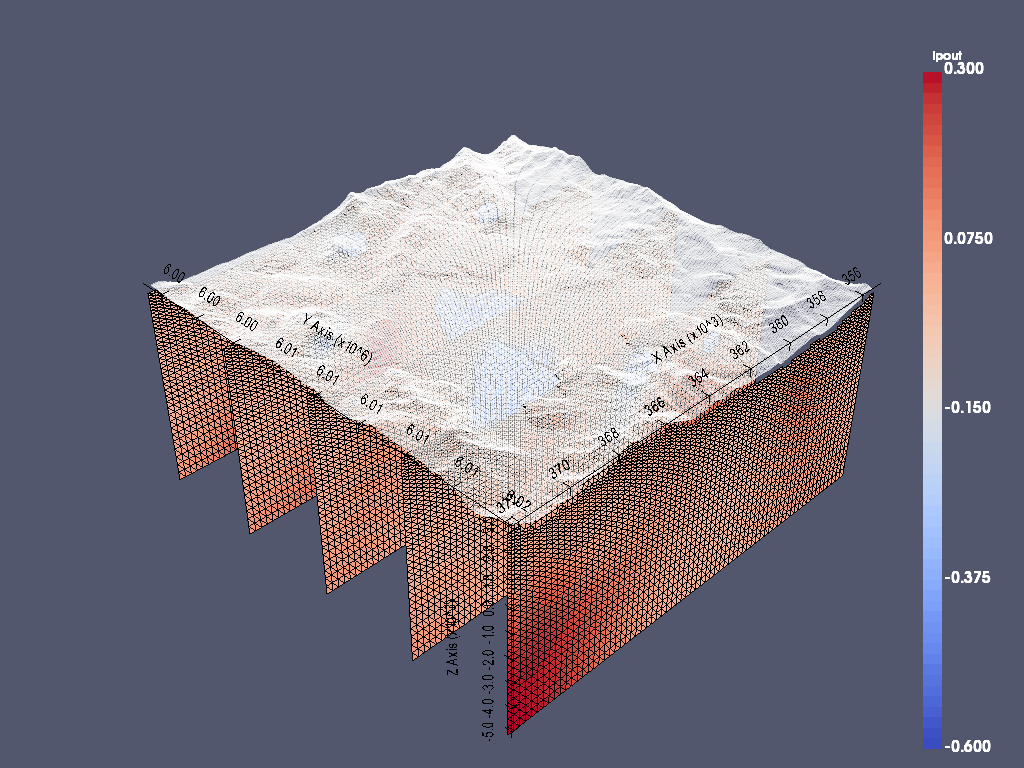

In [17]:
p = vtki.Plotter(notebook=True)
#p.add_mesh(extracted, syle='wireframe', opacity=0.25, scalars='lpout', rng=rng)
p.add_bounds_axes(extracted, color='k', fontsize=30)
p.add_mesh(low, scalars='lpout', stitle='lpout', rng=rng)
p.add_mesh(sliced, scalars='lpout', rng=rng)
p.add_mesh(topo, color='white', opacity=0.5, psize=1.0)
p.add_axes()
p.plot()

In [11]:
sliced

(MultiBlock)0x12b79fdc8

In [12]:
s = vtki.wrap(sliced)

In [13]:
s

(MultiBlock)0x115d059a8

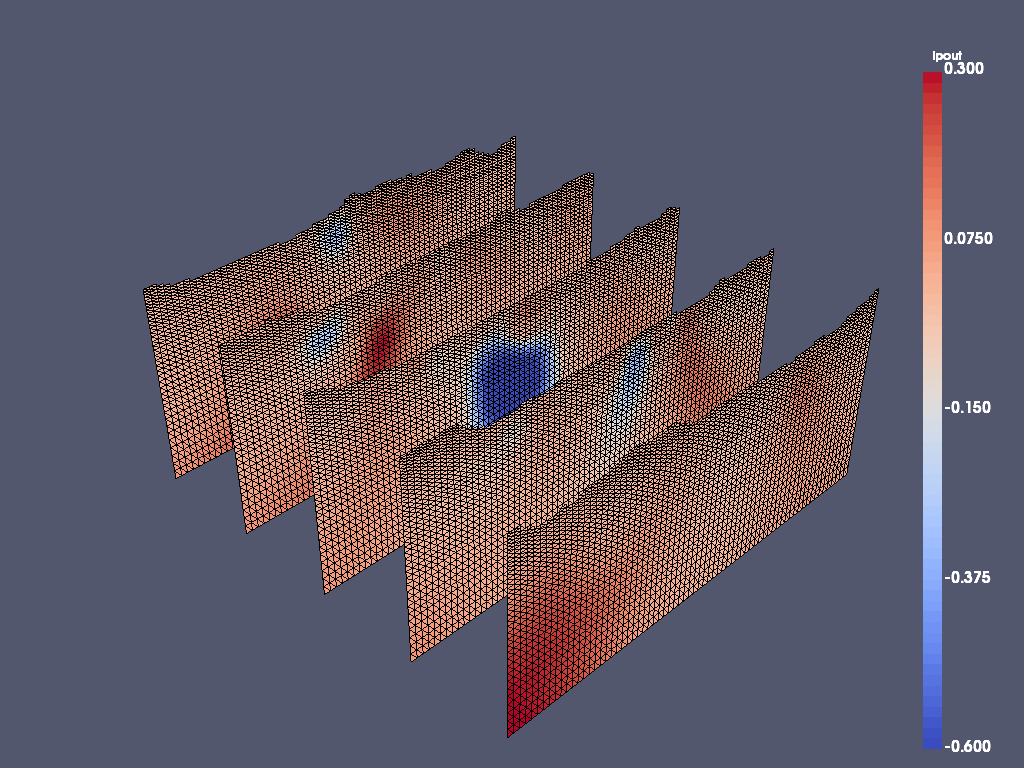

In [14]:
s.plot(scalars='lpout')